In [ ]:
!pip install kagglehub pennylane opencv-python-headless torch torchvision torchaudio scikit-learn

import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.cuda.amp as amp
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import kagglehub

torch.manual_seed(42)
np.random.seed(42)

path = kagglehub.dataset_download("sachinkumar413/diabetic-retinopathy-dataset")
print("Path to dataset files:", path)

class_names = ['healthy', 'mild', 'moderate', 'proliferative', 'severe']
num_classes = 5
n_qubits = 8
n_layers = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 127.1 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


100%|██████████| 350M/350M [00:02<00:00, 157MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sachinkumar413/diabetic-retinopathy-dataset/versions/1
Using device: cuda


## Enhanced Preprocessing with CLAHE

In [ ]:
class CLAHETransform:
    def __init__(self, clip_limit=3.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def __call__(self, img):
        img = np.array(img)
        if len(img.shape) == 3:
            lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            l_clahe = self.clahe.apply(l)
            lab_clahe = cv2.merge([l_clahe, a, b])
            img_enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
        else:
            img_enhanced = self.clahe.apply(img)
        return Image.fromarray(img_enhanced)

train_transform = transforms.Compose([
    CLAHETransform(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    CLAHETransform(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

full_dataset = datasets.ImageFolder(root=path, transform=None)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_indices = train_dataset.indices
test_indices = test_dataset.indices

train_dataset_transformed = torch.utils.data.Subset(
    datasets.ImageFolder(root=path, transform=train_transform), train_indices
)
test_dataset_transformed = torch.utils.data.Subset(
    datasets.ImageFolder(root=path, transform=test_transform), test_indices
)

train_labels = [full_dataset.targets[i] for i in train_indices]
class_counts = [0] * num_classes
for label in train_labels:
    class_counts[label] += 1

print("Training class distribution:", dict(zip(class_names, class_counts)))

weights = [1.0 / class_counts[label] for label in train_labels]
sampler = WeightedRandomSampler(weights, len(train_labels))

batch_size = 16
train_loader = DataLoader(train_dataset_transformed, batch_size=batch_size,
                         sampler=sampler, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset_transformed, batch_size=batch_size,
                        shuffle=False, num_workers=2, pin_memory=True)

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

Training class distribution: {'healthy': 803, 'mild': 296, 'moderate': 714, 'proliferative': 238, 'severe': 149}
Training samples: 2200
Test samples: 550


## Enhanced VQE Quantum Circuit


ENHANCED VQE QUANTUM CIRCUIT
0: ──RX(2.93)──Rot(3.96,5.00,2.43)─╭●───────────────────╭X──Rot(1.44,5.12,0.99)─╭●──────────── ···
1: ──RX(2.87)──Rot(5.42,5.93,0.73)─╰X─╭●────────────────│───Rot(2.88,4.45,0.39)─│──╭●───────── ···
2: ──RX(2.15)──Rot(5.72,1.07,0.98)────╰X─╭●─────────────│───Rot(5.57,1.71,2.29)─╰X─│──╭●────── ···
3: ──RX(3.14)──Rot(0.52,4.05,0.78)───────╰X─╭●──────────│───Rot(1.22,1.97,1.93)────╰X─│──╭●─── ···
4: ──RX(2.47)──Rot(1.96,1.56,3.98)──────────╰X─╭●───────│───Rot(0.35,4.22,3.13)───────╰X─│──╭● ···
5: ──RX(2.49)──Rot(0.06,1.70,3.16)─────────────╰X─╭●────│───Rot(6.21,5.26,5.87)──────────╰X─│─ ···
6: ──RX(1.04)──Rot(3.42,1.72,4.27)────────────────╰X─╭●─│───Rot(4.07,4.79,6.08)─────────────╰X ···
7: ──RX(3.03)──Rot(1.07,0.48,2.69)───────────────────╰X─╰●──Rot(5.72,0.73,2.44)─────────────── ···

0: ··· ────╭X──Rot(0.11,3.26,2.03)──────────────────────╭●─────────────╭X──Rot(1.07,4.84,1.47) ···
1: ··· ────│──╭X────────────────────Rot(5.87,3.64,3.18)─│──╭●──────────│──╭X──

/tmp/ipython-input-4292852821.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


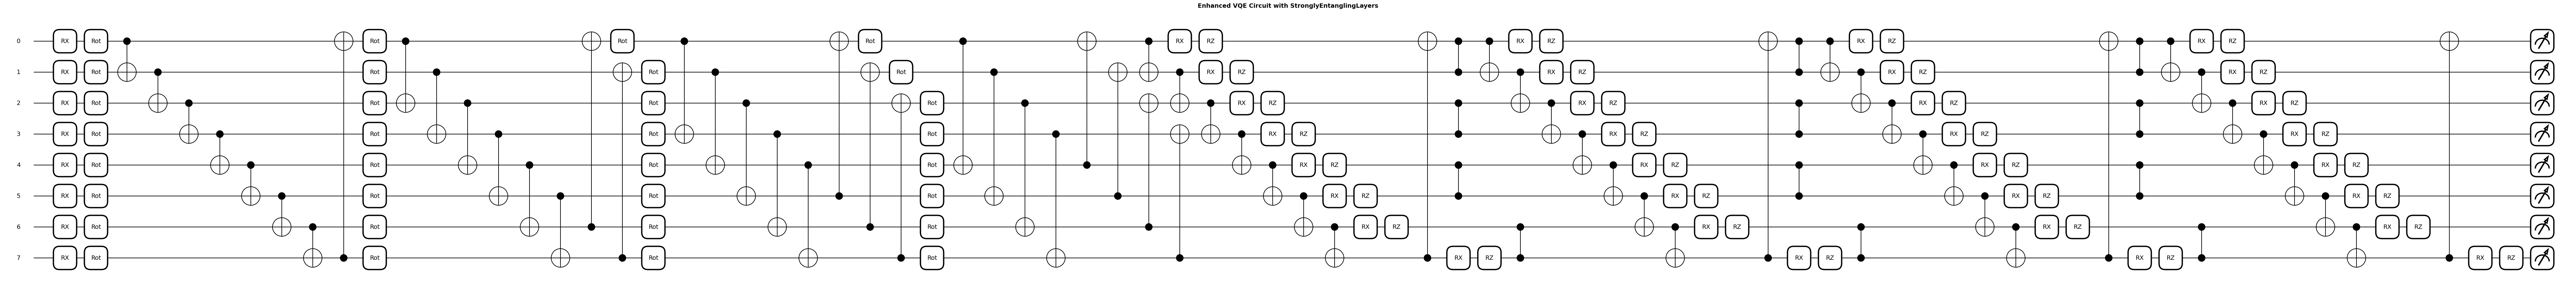


Circuit Specifications:
  Qubits: 8
  Variational Layers: 4
  Total Parameters: 192
  Output Dimension: 16 (expval + variance)
  Gates: AngleEmbedding + StronglyEntangling + RX/RZ/CNOT/CZ



In [ ]:
dev_vqe = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev_vqe, interface="torch")
def enhanced_vqe_circuit(inputs, weights):

    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    qml.StronglyEntanglingLayers(weights[:n_layers], wires=range(n_qubits))


    for layer in range(n_layers):

        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])
            qml.RX(weights[n_layers + layer, i, 0], wires=i)
            qml.RZ(weights[n_layers + layer, i, 1], wires=i)


        if layer < n_layers - 1:
            for i in range(0, n_qubits - 1, 2):
                qml.CZ(wires=[i, i + 1])


    expval = [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    variance = [qml.var(qml.PauliZ(i)) for i in range(n_qubits)]

    return expval + variance


vqe_weight_shapes = {"weights": (n_layers * 2, n_qubits, 3)}

print("\n" + "="*60)
print("ENHANCED VQE QUANTUM CIRCUIT")
print("="*60)


dummy_inputs = torch.rand(n_qubits) * np.pi
dummy_weights = torch.rand(n_layers * 2, n_qubits, 3) * 2 * np.pi

print(qml.draw(enhanced_vqe_circuit, level="device", max_length=100)(dummy_inputs, dummy_weights))

fig, ax = qml.draw_mpl(enhanced_vqe_circuit, level="device")(dummy_inputs, dummy_weights)
plt.title("Enhanced VQE Circuit with StronglyEntanglingLayers", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCircuit Specifications:")
print(f"  Qubits: {n_qubits}")
print(f"  Variational Layers: {n_layers}")
print(f"  Total Parameters: {n_layers * 2 * n_qubits * 3}")
print(f"  Output Dimension: {n_qubits * 2} (expval + variance)")
print(f"  Gates: AngleEmbedding + StronglyEntangling + RX/RZ/CNOT/CZ")
print("="*60 + "\n")

## Focal Loss for Class Imbalance

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

## Hybrid Quantum-Classical Model

In [ ]:
class EnhancedVQEHybridModel(nn.Module):
    def __init__(self, num_classes=5):
        super(EnhancedVQEHybridModel, self).__init__()

        # Use ResNet50 backbone (all layers trainable)
        self.backbone = resnet50(weights=ResNet50_Weights.DEFAULT)

        # Store target layer for Grad-CAM
        self.target_layer = self.backbone.layer4[-1]

        # Unfreeze all layers for full fine-tuning
        for param in self.backbone.parameters():
            param.requires_grad = True

        in_features = self.backbone.fc.in_features

        # Feature extraction to vector representation
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, n_qubits)  # Output vector for quantum processing
        )

        # Quantum layer with enhanced VQE circuit
        self.quantum_layer = qml.qnn.TorchLayer(enhanced_vqe_circuit, vqe_weight_shapes)

        # Classifier (maps quantum output to classes)
        self.classifier = nn.Sequential(
            nn.Linear(n_qubits * 2, 256),  # n_qubits*2 because we get expval + variance
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Extract features as vectors
        features = self.backbone(x)  # Shape: (batch_size, n_qubits)

        # Normalize to [0, π] for quantum encoding
        features = torch.pi * torch.sigmoid(features)

        # Process through quantum layer (handles batching internally)
        quantum_output = self.quantum_layer(features)  # Shape: (batch_size, n_qubits*2)

        # Classification
        output = self.classifier(quantum_output)

        return output

## Grad-CAM for Visualization

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_image, target_class=None):
        model_output = self.model(input_image)

        if target_class is None:
            target_class = model_output.argmax(dim=1).item()

        self.model.zero_grad()
        class_loss = model_output[0, target_class]
        class_loss.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])

        for i in range(self.activations.size(1)):
            self.activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(self.activations, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)

        return heatmap.cpu().numpy(), target_class

def visualize_gradcam(original_img, heatmap, alpha=0.4):
    """Overlay heatmap on original image"""
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    original_img_uint8 = np.uint8(original_img)
    superimposed_img = cv2.addWeighted(original_img_uint8, 1-alpha, heatmap_colored, alpha, 0)

    return superimposed_img

## Training Functions

In [ ]:
def train_epoch(model, loader, optimizer, criterion, device, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Mixed precision training
        with amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if batch_idx % 10 == 0:
            print(f"  Batch [{batch_idx}/{len(loader)}] Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(loader)
    val_acc = correct / total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    return val_loss, val_acc, val_f1, all_labels, all_preds

def train_model(model, train_loader, test_loader, criterion, optimizer,
                scheduler, num_epochs, device, model_name):
    print(f"\n{'='*60}")
    print(f"TRAINING {model_name.upper()}")
    print(f"{'='*60}\n")

    model.to(device)
    scaler = amp.GradScaler()
    best_acc = 0
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")

        train_loss, train_acc = train_epoch(model, train_loader, optimizer,
                                           criterion, device, scaler)
        val_loss, val_acc, val_f1, val_labels, val_preds = validate(
            model, test_loader, criterion, device
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"\n{model_name} - Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
        print(f"  Val F1 Score: {val_f1:.4f}")

        scheduler.step()

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            safe_name = model_name.lower().replace(" ", "_").replace("+", "")
            torch.save(model.state_dict(), f'best_{safe_name}.pth')
            print(f"  ✓ New best model saved! Accuracy: {best_acc*100:.2f}%")

    # Plot training curves
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(train_losses, label='Train Loss', linewidth=2)
    axes[0].plot(val_losses, label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{model_name} - Loss Curves')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot([acc*100 for acc in train_accs], label='Train Acc', linewidth=2)
    axes[1].plot([acc*100 for acc in val_accs], label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].set_title(f'{model_name} - Accuracy Curves')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(val_labels, val_preds)
    plt.figure(figsize=(10, 8))
    import seaborn as sns
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Classification report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(val_labels, val_preds, target_names=class_names))

    return best_acc, val_f1

## Main Training Pipeline


STARTING ENHANCED QUANTUM DR DETECTION
WITH VECTOR-BASED QUANTUM PROCESSING

Training Enhanced VQE Quantum Hybrid Model...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 112MB/s]



TRAINING VQE QUANTUM HYBRID


Epoch [1/20]


/tmp/ipython-input-2969189716.py:71: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
/tmp/ipython-input-2969189716.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
/usr/local/lib/python3.12/dist-packages/pennylane/ops/qubit/parametric_ops_single_qubit.py:127: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at /pytorch/aten/src/ATen/EmptyTensor.cpp:55.)
  c = (1 + 0j) * c


  Batch [0/138] Loss: 1.1095
  Batch [10/138] Loss: 1.1000
  Batch [20/138] Loss: 1.1024
  Batch [30/138] Loss: 1.1500
  Batch [40/138] Loss: 1.0880
  Batch [50/138] Loss: 0.9348
  Batch [60/138] Loss: 1.0307
  Batch [70/138] Loss: 0.8721
  Batch [80/138] Loss: 0.7772
  Batch [90/138] Loss: 0.9103
  Batch [100/138] Loss: 1.0496
  Batch [110/138] Loss: 1.0524
  Batch [120/138] Loss: 0.7812
  Batch [130/138] Loss: 0.5959

VQE Quantum Hybrid - Epoch 1/20
  Train Loss: 0.9708, Train Acc: 30.73%
  Val Loss: 0.6482, Val Acc: 58.18%
  Val F1 Score: 0.5306
  ✓ New best model saved! Accuracy: 58.18%

Epoch [2/20]


/tmp/ipython-input-2969189716.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  Batch [0/138] Loss: 0.8466
  Batch [10/138] Loss: 1.1399
  Batch [20/138] Loss: 0.8771
  Batch [30/138] Loss: 0.9593
  Batch [40/138] Loss: 0.7427
  Batch [50/138] Loss: 0.8796
  Batch [60/138] Loss: 1.0427
  Batch [70/138] Loss: 0.6056
  Batch [80/138] Loss: 0.8092
  Batch [90/138] Loss: 0.8891
  Batch [100/138] Loss: 0.6058
  Batch [110/138] Loss: 0.8777
  Batch [120/138] Loss: 0.6048
  Batch [130/138] Loss: 0.6000

VQE Quantum Hybrid - Epoch 2/20
  Train Loss: 0.8083, Train Acc: 40.50%
  Val Loss: 0.6551, Val Acc: 50.91%
  Val F1 Score: 0.4477

Epoch [3/20]


/tmp/ipython-input-2969189716.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  Batch [0/138] Loss: 0.8007
  Batch [10/138] Loss: 0.6003
  Batch [20/138] Loss: 0.5671
  Batch [30/138] Loss: 0.6929
  Batch [40/138] Loss: 1.1745
  Batch [50/138] Loss: 0.5896
  Batch [60/138] Loss: 0.9734
  Batch [70/138] Loss: 0.7330
  Batch [80/138] Loss: 0.8276
  Batch [90/138] Loss: 0.6491
  Batch [100/138] Loss: 0.7465
  Batch [110/138] Loss: 0.5845
  Batch [120/138] Loss: 0.8862
  Batch [130/138] Loss: 0.8207

VQE Quantum Hybrid - Epoch 3/20
  Train Loss: 0.7605, Train Acc: 43.00%
  Val Loss: 0.5808, Val Acc: 53.09%
  Val F1 Score: 0.4785

Epoch [4/20]


/tmp/ipython-input-2969189716.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  Batch [0/138] Loss: 0.6739
  Batch [10/138] Loss: 0.6576
  Batch [20/138] Loss: 0.6949
  Batch [30/138] Loss: 0.7655
  Batch [40/138] Loss: 0.5389
  Batch [50/138] Loss: 0.6638
  Batch [60/138] Loss: 0.6066
  Batch [70/138] Loss: 0.7468
  Batch [80/138] Loss: 0.7067
  Batch [90/138] Loss: 0.7487
  Batch [100/138] Loss: 0.6809
  Batch [110/138] Loss: 0.6020
  Batch [120/138] Loss: 0.5665
  Batch [130/138] Loss: 0.6360

VQE Quantum Hybrid - Epoch 4/20
  Train Loss: 0.7012, Train Acc: 46.36%
  Val Loss: 0.5601, Val Acc: 54.55%
  Val F1 Score: 0.4984

Epoch [5/20]


/tmp/ipython-input-2969189716.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  Batch [0/138] Loss: 0.8311
  Batch [10/138] Loss: 0.5519
  Batch [20/138] Loss: 0.8230
  Batch [30/138] Loss: 0.6679
  Batch [40/138] Loss: 0.5304
  Batch [50/138] Loss: 0.6395
  Batch [60/138] Loss: 0.5378
  Batch [70/138] Loss: 0.8294
  Batch [80/138] Loss: 0.4824
  Batch [90/138] Loss: 0.5519
  Batch [100/138] Loss: 0.7245
  Batch [110/138] Loss: 0.6523
  Batch [120/138] Loss: 0.6625
  Batch [130/138] Loss: 0.5317

VQE Quantum Hybrid - Epoch 5/20
  Train Loss: 0.6270, Train Acc: 51.27%
  Val Loss: 0.5202, Val Acc: 60.18%
  Val F1 Score: 0.5634
  ✓ New best model saved! Accuracy: 60.18%

Epoch [6/20]


/tmp/ipython-input-2969189716.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  Batch [0/138] Loss: 0.5844
  Batch [10/138] Loss: 0.3706
  Batch [20/138] Loss: 0.5313
  Batch [30/138] Loss: 0.6103
  Batch [40/138] Loss: 0.5488
  Batch [50/138] Loss: 0.5541
  Batch [60/138] Loss: 0.4429
  Batch [70/138] Loss: 0.7796
  Batch [80/138] Loss: 0.6838
  Batch [90/138] Loss: 0.5171
  Batch [100/138] Loss: 0.5805
  Batch [110/138] Loss: 0.4161
  Batch [120/138] Loss: 0.5053
  Batch [130/138] Loss: 0.5965

VQE Quantum Hybrid - Epoch 6/20
  Train Loss: 0.5961, Train Acc: 51.59%
  Val Loss: 0.5028, Val Acc: 60.36%
  Val F1 Score: 0.5746
  ✓ New best model saved! Accuracy: 60.36%

Epoch [7/20]


/tmp/ipython-input-2969189716.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  Batch [0/138] Loss: 0.6743
  Batch [10/138] Loss: 0.5591
  Batch [20/138] Loss: 0.7534
  Batch [30/138] Loss: 0.7782
  Batch [40/138] Loss: 0.6035
  Batch [50/138] Loss: 0.5287
  Batch [60/138] Loss: 0.4642
  Batch [70/138] Loss: 0.4282
  Batch [80/138] Loss: 0.3513
  Batch [90/138] Loss: 0.6662
  Batch [100/138] Loss: 0.6578
  Batch [110/138] Loss: 0.3992
  Batch [120/138] Loss: 0.5393
  Batch [130/138] Loss: 0.6109

VQE Quantum Hybrid - Epoch 7/20
  Train Loss: 0.5991, Train Acc: 52.68%
  Val Loss: 0.4457, Val Acc: 64.73%
  Val F1 Score: 0.6333
  ✓ New best model saved! Accuracy: 64.73%

Epoch [8/20]


/tmp/ipython-input-2969189716.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  Batch [0/138] Loss: 0.6304
  Batch [10/138] Loss: 0.7702
  Batch [20/138] Loss: 0.5548
  Batch [30/138] Loss: 0.6929
  Batch [40/138] Loss: 0.8057
  Batch [50/138] Loss: 0.7514
  Batch [60/138] Loss: 0.4109
  Batch [70/138] Loss: 0.4182
  Batch [80/138] Loss: 0.5141
  Batch [90/138] Loss: 0.6004
  Batch [100/138] Loss: 0.3761
  Batch [110/138] Loss: 0.7308
  Batch [120/138] Loss: 0.4443
  Batch [130/138] Loss: 0.4441

VQE Quantum Hybrid - Epoch 8/20
  Train Loss: 0.5697, Train Acc: 54.73%
  Val Loss: 0.4341, Val Acc: 65.09%
  Val F1 Score: 0.6336
  ✓ New best model saved! Accuracy: 65.09%

Epoch [9/20]


/tmp/ipython-input-2969189716.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  Batch [0/138] Loss: 0.3864
  Batch [10/138] Loss: 0.4805
  Batch [20/138] Loss: 0.5197
  Batch [30/138] Loss: 0.4418
  Batch [40/138] Loss: 0.4769
  Batch [50/138] Loss: 0.6789
  Batch [60/138] Loss: 0.4989
  Batch [70/138] Loss: 0.4992
  Batch [80/138] Loss: 0.4260
  Batch [90/138] Loss: 0.6889
  Batch [100/138] Loss: 0.5823
  Batch [110/138] Loss: 0.4102
  Batch [120/138] Loss: 0.4536
  Batch [130/138] Loss: 0.4577

VQE Quantum Hybrid - Epoch 9/20
  Train Loss: 0.5556, Train Acc: 55.86%
  Val Loss: 0.4313, Val Acc: 66.18%
  Val F1 Score: 0.6537
  ✓ New best model saved! Accuracy: 66.18%

Epoch [10/20]


/tmp/ipython-input-2969189716.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  Batch [0/138] Loss: 0.4647
  Batch [10/138] Loss: 0.5994
  Batch [20/138] Loss: 0.5938
  Batch [30/138] Loss: 0.6926
  Batch [40/138] Loss: 0.5021
  Batch [50/138] Loss: 0.5084
  Batch [60/138] Loss: 0.5104
  Batch [70/138] Loss: 0.5138
  Batch [80/138] Loss: 0.6774
  Batch [90/138] Loss: 0.7548
  Batch [100/138] Loss: 0.4630
  Batch [110/138] Loss: 0.4212
  Batch [120/138] Loss: 0.9385
  Batch [130/138] Loss: 0.5821

VQE Quantum Hybrid - Epoch 10/20
  Train Loss: 0.5235, Train Acc: 57.41%
  Val Loss: 0.4264, Val Acc: 68.55%
  Val F1 Score: 0.6822
  ✓ New best model saved! Accuracy: 68.55%

Epoch [11/20]


/tmp/ipython-input-2969189716.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  Batch [0/138] Loss: 0.5204
  Batch [10/138] Loss: 0.5355
  Batch [20/138] Loss: 0.4103
  Batch [30/138] Loss: 0.4378
  Batch [40/138] Loss: 0.6639
  Batch [50/138] Loss: 0.6099
  Batch [60/138] Loss: 0.7639
  Batch [70/138] Loss: 0.4013
  Batch [80/138] Loss: 0.5418
  Batch [90/138] Loss: 0.5222
  Batch [100/138] Loss: 0.4056
  Batch [110/138] Loss: 0.6739
  Batch [120/138] Loss: 0.4333
  Batch [130/138] Loss: 0.3489

VQE Quantum Hybrid - Epoch 11/20
  Train Loss: 0.5279, Train Acc: 58.05%
  Val Loss: 0.4012, Val Acc: 66.91%
  Val F1 Score: 0.6664

Epoch [12/20]


/tmp/ipython-input-2969189716.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  Batch [0/138] Loss: 0.3245
  Batch [10/138] Loss: 0.4994
  Batch [20/138] Loss: 0.6957
  Batch [30/138] Loss: 0.6419
  Batch [40/138] Loss: 0.4803
  Batch [50/138] Loss: 0.8573
  Batch [60/138] Loss: 0.3504
  Batch [70/138] Loss: 0.5222
  Batch [80/138] Loss: 0.6514
  Batch [90/138] Loss: 0.8390
  Batch [100/138] Loss: 0.3979
  Batch [110/138] Loss: 0.4197
  Batch [120/138] Loss: 0.6367
  Batch [130/138] Loss: 0.4020

VQE Quantum Hybrid - Epoch 12/20
  Train Loss: 0.4981, Train Acc: 59.73%
  Val Loss: 0.4117, Val Acc: 66.73%
  Val F1 Score: 0.6609

Epoch [13/20]


/tmp/ipython-input-2969189716.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  Batch [0/138] Loss: 0.5452
  Batch [10/138] Loss: 0.4970
  Batch [20/138] Loss: 0.3265
  Batch [30/138] Loss: 0.4128
  Batch [40/138] Loss: 0.4200
  Batch [50/138] Loss: 0.4302
  Batch [60/138] Loss: 0.4952
  Batch [70/138] Loss: 0.4215
  Batch [80/138] Loss: 0.7124
  Batch [90/138] Loss: 0.3407
  Batch [100/138] Loss: 0.3496
  Batch [110/138] Loss: 0.3603
  Batch [120/138] Loss: 0.4411
  Batch [130/138] Loss: 0.8791

VQE Quantum Hybrid - Epoch 13/20
  Train Loss: 0.4958, Train Acc: 59.73%
  Val Loss: 0.4018, Val Acc: 67.64%
  Val F1 Score: 0.6675

Epoch [14/20]


/tmp/ipython-input-2969189716.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  Batch [0/138] Loss: 0.5826
  Batch [10/138] Loss: 0.4549
  Batch [20/138] Loss: 0.3821
  Batch [30/138] Loss: 0.5095
  Batch [40/138] Loss: 0.4423
  Batch [50/138] Loss: 0.3385
  Batch [60/138] Loss: 0.3931
  Batch [70/138] Loss: 0.3663
  Batch [80/138] Loss: 0.3191
  Batch [90/138] Loss: 0.5060
  Batch [100/138] Loss: 0.2889
  Batch [110/138] Loss: 0.4918
  Batch [120/138] Loss: 0.8817
  Batch [130/138] Loss: 0.3430

VQE Quantum Hybrid - Epoch 14/20
  Train Loss: 0.4873, Train Acc: 60.59%
  Val Loss: 0.3941, Val Acc: 68.36%
  Val F1 Score: 0.6747

Epoch [15/20]


/tmp/ipython-input-2969189716.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  Batch [0/138] Loss: 0.6346
  Batch [10/138] Loss: 0.3862
  Batch [20/138] Loss: 0.5345
  Batch [30/138] Loss: 0.5614
  Batch [40/138] Loss: 0.3928
  Batch [50/138] Loss: 0.3825
  Batch [60/138] Loss: 0.6387
  Batch [70/138] Loss: 0.2791
  Batch [80/138] Loss: 0.3191
  Batch [90/138] Loss: 0.4458
  Batch [100/138] Loss: 0.5963
  Batch [110/138] Loss: 0.3516
  Batch [120/138] Loss: 0.4501
  Batch [130/138] Loss: 1.0880

VQE Quantum Hybrid - Epoch 15/20
  Train Loss: 0.4791, Train Acc: 61.27%
  Val Loss: 0.3798, Val Acc: 69.09%
  Val F1 Score: 0.6858
  ✓ New best model saved! Accuracy: 69.09%

Epoch [16/20]


/tmp/ipython-input-2969189716.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  Batch [0/138] Loss: 0.5105
  Batch [10/138] Loss: 0.5522
  Batch [20/138] Loss: 0.7145
  Batch [30/138] Loss: 0.3651
  Batch [40/138] Loss: 0.4278
  Batch [50/138] Loss: 0.5374
  Batch [60/138] Loss: 0.5621
  Batch [70/138] Loss: 0.4498
  Batch [80/138] Loss: 0.3638
  Batch [90/138] Loss: 0.5711
  Batch [100/138] Loss: 0.3120
  Batch [110/138] Loss: 0.3854
  Batch [120/138] Loss: 0.3530
  Batch [130/138] Loss: 0.3577

VQE Quantum Hybrid - Epoch 16/20
  Train Loss: 0.4648, Train Acc: 61.14%
  Val Loss: 0.3678, Val Acc: 71.45%
  Val F1 Score: 0.7085
  ✓ New best model saved! Accuracy: 71.45%

Epoch [17/20]


/tmp/ipython-input-2969189716.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  Batch [0/138] Loss: 0.4542
  Batch [10/138] Loss: 0.4280
  Batch [20/138] Loss: 0.7788
  Batch [30/138] Loss: 0.4042
  Batch [40/138] Loss: 0.3481
  Batch [50/138] Loss: 0.5011
  Batch [60/138] Loss: 0.7097
  Batch [70/138] Loss: 0.5154
  Batch [80/138] Loss: 0.5059
  Batch [90/138] Loss: 0.5277
  Batch [100/138] Loss: 0.4940
  Batch [110/138] Loss: 0.6699
  Batch [120/138] Loss: 0.5172
  Batch [130/138] Loss: 0.4017

VQE Quantum Hybrid - Epoch 17/20
  Train Loss: 0.4747, Train Acc: 60.36%
  Val Loss: 0.3672, Val Acc: 71.45%
  Val F1 Score: 0.7083

Epoch [18/20]


/tmp/ipython-input-2969189716.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  Batch [0/138] Loss: 0.3169
  Batch [10/138] Loss: 0.3675
  Batch [20/138] Loss: 0.5025
  Batch [30/138] Loss: 0.3352
  Batch [40/138] Loss: 0.3926
  Batch [50/138] Loss: 0.2691
  Batch [60/138] Loss: 0.5624
  Batch [70/138] Loss: 0.4274
  Batch [80/138] Loss: 0.5294
  Batch [90/138] Loss: 0.3392
  Batch [100/138] Loss: 0.4447
  Batch [110/138] Loss: 0.6128
  Batch [120/138] Loss: 0.4042
  Batch [130/138] Loss: 0.3278

VQE Quantum Hybrid - Epoch 18/20
  Train Loss: 0.4414, Train Acc: 63.59%
  Val Loss: 0.3833, Val Acc: 70.36%
  Val F1 Score: 0.6966

Epoch [19/20]


/tmp/ipython-input-2969189716.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  Batch [0/138] Loss: 0.3969
  Batch [10/138] Loss: 0.3051
  Batch [20/138] Loss: 0.5054
  Batch [30/138] Loss: 0.3044
  Batch [40/138] Loss: 0.5124
  Batch [50/138] Loss: 0.4716
  Batch [60/138] Loss: 0.5510
  Batch [70/138] Loss: 0.3064
  Batch [80/138] Loss: 0.3133
  Batch [90/138] Loss: 0.4700
  Batch [100/138] Loss: 0.7587
  Batch [110/138] Loss: 0.6264
  Batch [120/138] Loss: 0.3827
  Batch [130/138] Loss: 0.3548

VQE Quantum Hybrid - Epoch 19/20
  Train Loss: 0.4558, Train Acc: 62.45%
  Val Loss: 0.3859, Val Acc: 69.64%
  Val F1 Score: 0.6885

Epoch [20/20]


/tmp/ipython-input-2969189716.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


  Batch [0/138] Loss: 0.6851
  Batch [10/138] Loss: 0.4293
  Batch [20/138] Loss: 0.3466
  Batch [30/138] Loss: 0.4511
  Batch [40/138] Loss: 0.3194
  Batch [50/138] Loss: 0.3396
  Batch [60/138] Loss: 0.3737
  Batch [70/138] Loss: 0.4788
  Batch [80/138] Loss: 0.3565
  Batch [90/138] Loss: 0.3766
  Batch [100/138] Loss: 0.5747
  Batch [110/138] Loss: 0.5914
  Batch [120/138] Loss: 0.3007
  Batch [130/138] Loss: 0.3324

VQE Quantum Hybrid - Epoch 20/20
  Train Loss: 0.4534, Train Acc: 62.45%
  Val Loss: 0.3828, Val Acc: 69.82%
  Val F1 Score: 0.6914


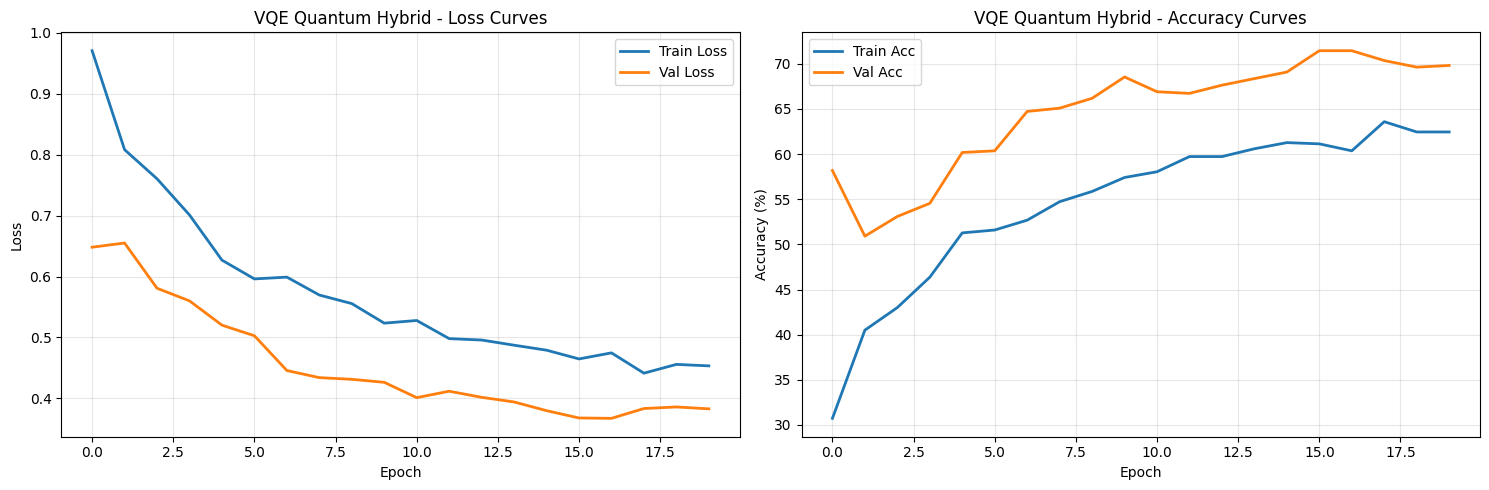

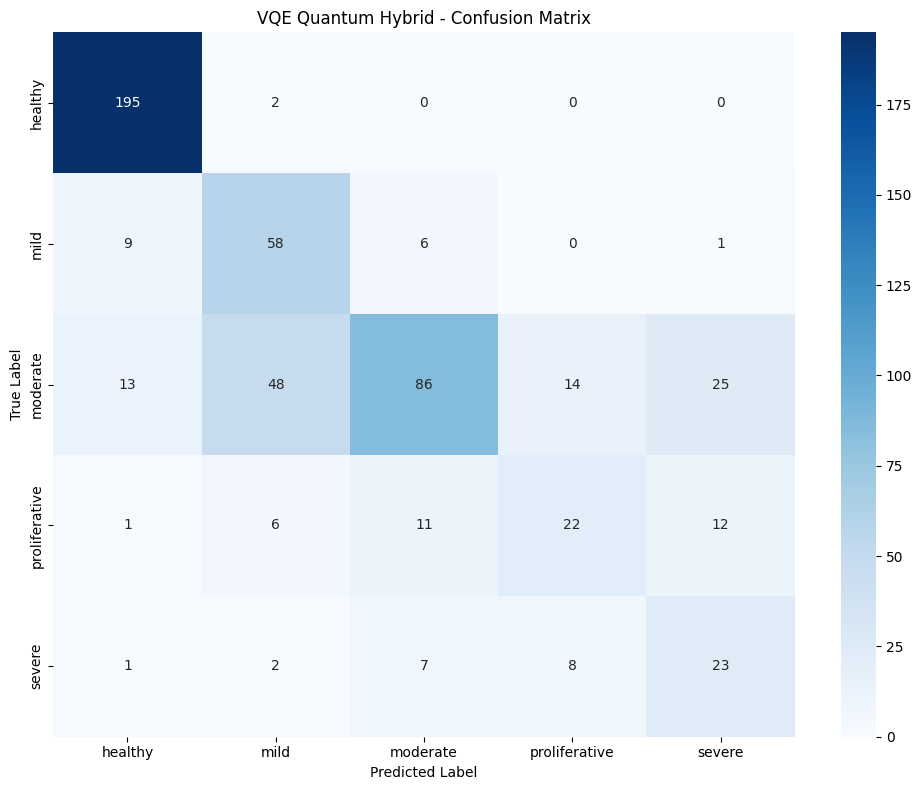


VQE Quantum Hybrid Classification Report:
               precision    recall  f1-score   support

      healthy       0.89      0.99      0.94       197
         mild       0.50      0.78      0.61        74
     moderate       0.78      0.46      0.58       186
proliferative       0.50      0.42      0.46        52
       severe       0.38      0.56      0.45        41

     accuracy                           0.70       550
    macro avg       0.61      0.64      0.61       550
 weighted avg       0.73      0.70      0.69       550


✓ Best model loaded! Final Accuracy: 71.45%


In [ ]:
print("\n" + "="*60)
print("STARTING ENHANCED QUANTUM DR DETECTION")
print("WITH VECTOR-BASED QUANTUM PROCESSING")
print("="*60)

num_epochs = 20
criterion = FocalLoss(alpha=1, gamma=2)

# Train VQE Quantum Hybrid Model
print("\nTraining Enhanced VQE Quantum Hybrid Model...")
model = EnhancedVQEHybridModel(num_classes)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

best_acc, best_f1 = train_model(
    model, train_loader, test_loader, criterion,
    optimizer, scheduler, num_epochs, device,
    "VQE Quantum Hybrid"
)

# Load best model
model.load_state_dict(torch.load('best_vqe_quantum_hybrid.pth'))
print(f"\n✓ Best model loaded! Final Accuracy: {best_acc*100:.2f}%")

## Single Image Prediction with Grad-CAM


SINGLE IMAGE PREDICTION WITH GRAD-CAM

Please upload an image for prediction...


Saving Severe DR_105.png to Severe DR_105.png

Processing image: Severe DR_105.png
Generating predictions with Grad-CAM...


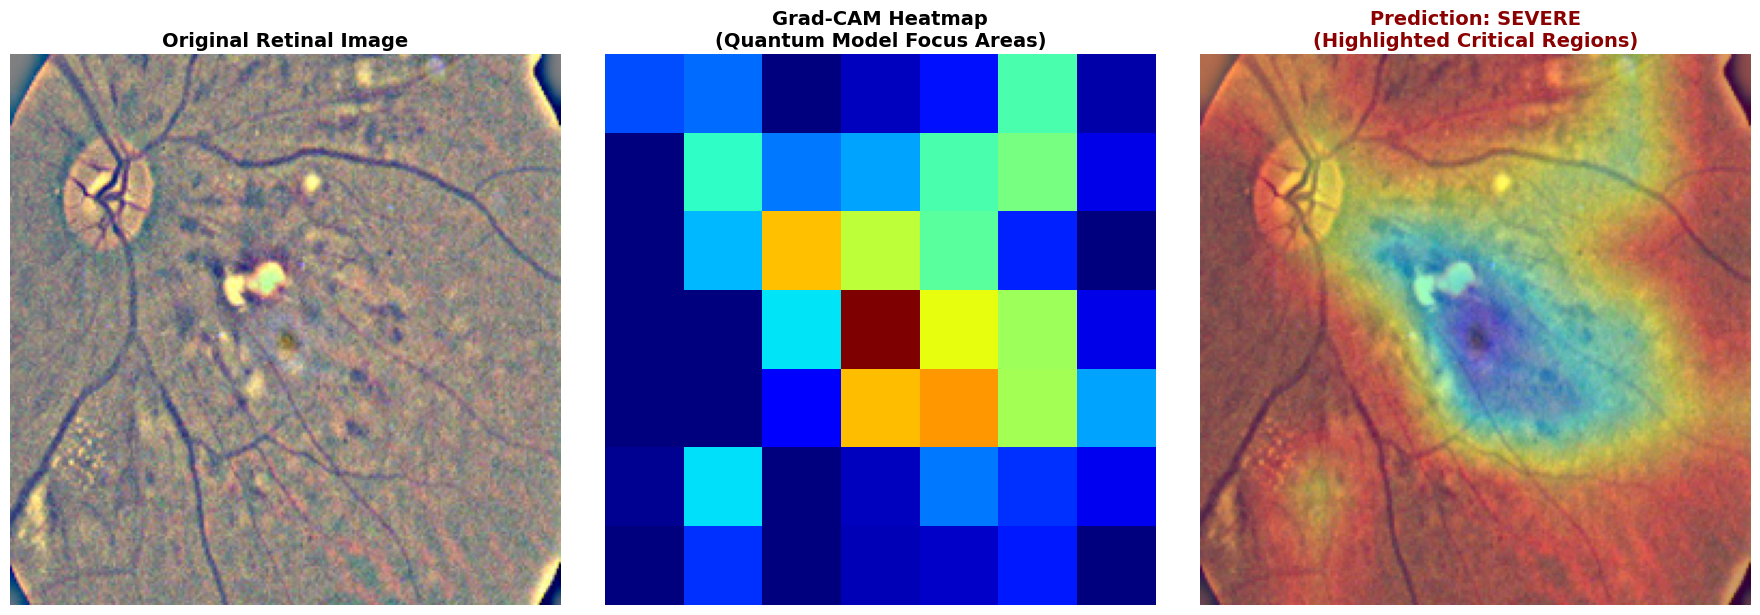


QUANTUM HYBRID MODEL PREDICTION RESULTS

Image: Severe DR_105.png
Predicted Class: SEVERE
Confidence: 38.43%

All Class Probabilities:
------------------------------------------------------------
    healthy        :   1.94% 
    mild           :   2.77% █
    moderate       :  25.39% ████████████
    proliferative  :  31.47% ███████████████
★★★ severe         :  38.43% ███████████████████

CLINICAL INTERPRETATION:
⚠⚠⚠ Proliferative diabetic retinopathy detected.
  Recommendation: URGENT - Immediate specialist consultation required.

Note: This is an AI-assisted diagnosis. Please consult with a
qualified ophthalmologist for professional medical advice.


In [ ]:
print("\n" + "="*60)
print("SINGLE IMAGE PREDICTION WITH GRAD-CAM")
print("="*60)

# Upload image
print("\nPlease upload an image for prediction...")
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Process image
print(f"\nProcessing image: {img_path}")
img_original = Image.open(img_path).convert('RGB')
img_transformed = test_transform(img_original).unsqueeze(0).to(device)

# Initialize Grad-CAM
gradcam = GradCAM(model, model.target_layer)

# Generate predictions and heatmap
print("Generating predictions with Grad-CAM...")
model.eval()
with torch.enable_grad():
    heatmap, predicted_class = gradcam.generate_cam(img_transformed)

# Get probabilities
with torch.no_grad():
    output = model(img_transformed)
    proba = F.softmax(output, dim=1)[0].cpu().numpy()

# Visualize results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image
axes[0].imshow(img_original)
axes[0].set_title('Original Retinal Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Heatmap
axes[1].imshow(heatmap, cmap='jet')
axes[1].set_title('Grad-CAM Heatmap\n(Quantum Model Focus Areas)', fontsize=14, fontweight='bold')
axes[1].axis('off')

# Overlay
img_array = np.array(img_original.resize((224, 224)))
superimposed = visualize_gradcam(img_array, heatmap)
axes[2].imshow(superimposed)
axes[2].set_title(f'Prediction: {class_names[predicted_class].upper()}\n(Highlighted Critical Regions)',
                  fontsize=14, fontweight='bold', color='darkgreen' if predicted_class == 0 else 'darkred')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Print detailed classification results
print("\n" + "="*60)
print("QUANTUM HYBRID MODEL PREDICTION RESULTS")
print("="*60)
print(f"\nImage: {img_path}")
print(f"Predicted Class: {class_names[predicted_class].upper()}")
print(f"Confidence: {proba[predicted_class]*100:.2f}%")
print("\nAll Class Probabilities:")
print("-" * 60)

for i, cls in enumerate(class_names):
    marker = "★★★" if i == predicted_class else "   "
    bar = "█" * int(proba[i] * 50)
    print(f"{marker} {cls:15s}: {proba[i]*100:6.2f}% {bar}")

print("="*60)

# Medical interpretation
print("\nCLINICAL INTERPRETATION:")
if predicted_class == 0:
    print("✓ No signs of diabetic retinopathy detected.")
    print("  Recommendation: Continue regular eye examinations.")
elif predicted_class == 1:
    print("⚠ Mild diabetic retinopathy detected.")
    print("  Recommendation: Increase monitoring frequency and control blood sugar.")
elif predicted_class == 2:
    print("⚠⚠ Moderate diabetic retinopathy detected.")
    print("  Recommendation: Consult ophthalmologist for treatment options.")
elif predicted_class == 3:
    print("⚠⚠⚠ Severe diabetic retinopathy detected.")
    print("  Recommendation: Immediate medical attention required.")
else:
    print("⚠⚠⚠ Proliferative diabetic retinopathy detected.")
    print("  Recommendation: URGENT - Immediate specialist consultation required.")

print("\nNote: This is an AI-assisted diagnosis. Please consult with a")
print("qualified ophthalmologist for professional medical advice.")
print("="*60)

## Batch Prediction (Optional)

In [ ]:
def predict_multiple_images():
    """Allow prediction on multiple images"""
    print("\n" + "="*60)
    print("BATCH PREDICTION MODE")
    print("="*60)

    print("\nUpload multiple images for batch prediction...")
    uploaded_batch = files.upload()

    results = []

    for img_name in uploaded_batch.keys():
        img = Image.open(img_name).convert('RGB')
        img_tensor = test_transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)
            proba = F.softmax(output, dim=1)[0].cpu().numpy()
            pred_class = output.argmax(dim=1).item()

        results.append({
            'Image': img_name,
            'Prediction': class_names[pred_class],
            'Confidence': f"{proba[pred_class]*100:.2f}%"
        })

    # Display results table
    import pandas as pd
    results_df = pd.DataFrame(results)
    print("\nBatch Prediction Results:")
    print(results_df.to_string(index=False))

    return results_df

# Uncomment to enable batch prediction
# predict_multiple_images()

print("\n" + "="*60)
print("QUANTUM HYBRID MODEL READY FOR INFERENCE!")
print("="*60)
print("\nModel saved as: best_vqe_quantum_hybrid.pth")
print("To predict on another image, run the 'SINGLE IMAGE PREDICTION' section again")
print("="*60)


QUANTUM HYBRID MODEL READY FOR INFERENCE!

Model saved as: best_vqe_quantum_hybrid.pth
To predict on another image, run the 'SINGLE IMAGE PREDICTION' section again
